# Библиотеки

In [1]:
import pandas as pd
import numpy as np

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from IPython.display import clear_output

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn

from torch import optim

from copy import deepcopy

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
from transformers import DistilBertTokenizerFast

In [8]:
import string

# Загрузка данных

In [9]:
data = pd.read_csv('data/words_250_000.csv')
data.head()

,address,name_ru,rating,rubrics,text,region,num_bad_words,num_good_words,text_len_in_symbols,text_len_in_words,mean_words_length
0,"Ростовская область, Таганрог, улица Комарова, 4",Beermarket,5,Магазин пива,"Отличный магазин. Хорошее пиво , приветливый п...",Ростовская область,0,2,128,19,6.736842
1,"Тюмень, улица Александра Логунова, 12/1",Пятёрочка,4,Супермаркет,"Персонал отличный, качество товара на хорошем ...",Тюмень,0,2,186,31,6.000000
2,"Москва, Аминьевское шоссе, 6",Kvartal West,5,Торговый центр,Торговый центр новый и очень чистый. Магазинов...,Москва,0,0,166,24,6.916667
3,"Оренбург, улица Монтажников, 23/1",Суперстройка,5,Строительный магазин,"Прекрасный магазин, у кого ремонт и стройка ре...",Оренбург,0,1,110,15,7.333333
4,"Рязань, улица Есенина, 42",Мебель Маркет 62,5,Магазин мебели,"Заказала кухню в мебель маркете, изготовили в ...",Рязань,0,1,323,44,7.340909


In [10]:
data = data[data['rating'] != data['rating'].min()]

In [11]:
data.rating = data.rating - 1

# Создание Датасета

In [12]:
train_texts, val_texts, train_labels, val_labels, train_features, val_features = train_test_split(data['text'].values.tolist(), data['rating'].values.tolist(),
                                     data[['num_bad_words', 'num_good_words', 'text_len_in_words', 'mean_words_length']].values.tolist(), test_size=0.2, random_state=22, stratify=data['rating'])

In [13]:
def text_preprocessing(text):
    for p in string.punctuation:
        if p in text:
            text = text.replace(p, '')
    text = text.lower()
    return text


class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, features):
        self.encodings = encodings
        self.labels = labels
        self.features = features
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['features'] = torch.tensor(self.features[idx], dtype=torch.float)
        return item
    
    def __len__(self):
        return len(self.labels)


# Очистка текста
cleaned_train_texts = [text_preprocessing(tweet) for tweet in train_texts]
cleaned_val_texts = [text_preprocessing(tweet) for tweet in val_texts]

# Токенизация текста
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(
    cleaned_train_texts,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"  # Возвращает словарь с `input_ids` и `attention_mask`
)

val_encodings = tokenizer(
    cleaned_val_texts,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

In [14]:
train_dataset = TweetDataset(train_encodings, train_labels, train_features)
val_dataset = TweetDataset(val_encodings, val_labels, val_features)

# Создание модели

In [162]:
class SimpleCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(SimpleCNN, self).__init__()

        # Embedding layer to transform token ids into vectors
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.embedding_dropout = nn.Dropout(p=0.3)

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * (128 // 4), 512),  # Макспулы влияют на длину
            nn.ReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, seq_len)
        x = self.embedding(x)  # -> (batch_size, seq_len, embed_dim)
        x = self.embedding_dropout(x)
        x = x.permute(0, 2, 1)  # -> (batch_size, embed_dim, seq_len)

        x = self.conv_layers(x)  # -> (batch_size, 256, seq_len//4)
        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc_layers(x)
        return x


In [178]:
import torch
import torch.nn as nn

class CNNWithFeatures(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, feature_dim):
        super(CNNWithFeatures, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # FC for text
        self.fc_text = nn.Sequential(
            nn.Linear(256 * (128 // 4), 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # FC for features
        self.fc_feat = nn.Sequential(
            nn.Linear(feature_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Final classifier
        self.fc_final = nn.Linear(128 + 32, num_classes)

    def forward(self, x_text, x_features):
        # Embedding and Conv
        x_text = self.embedding(x_text)             # (batch, seq_len, embed_dim)
        x_text = x_text.permute(0, 2, 1)            # (batch, embed_dim, seq_len)
        x_text = self.conv_layers(x_text)           # (batch, 256, seq_len//4)
        x_text = x_text.view(x_text.size(0), -1)    # Flatten
        x_text = self.fc_text(x_text)

        # Features branch
        x_features = self.fc_feat(x_features)

        # Combine
        x = torch.cat((x_text, x_features), dim=1)
        return self.fc_final(x)


In [163]:
class TextModelWithFeatures(nn.Module):
    def __init__(self, num_features, num_classes):
        super(TextModelWithFeatures, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.fc_text = nn.Linear(128 * (512 // 4), 128)
        
        self.fc_features = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
        self.fc_final = nn.Linear(128 + 32, num_classes)

    def forward(self, x_text):
        x_text = x_text.float()
        # Сверточная часть для текста
        x_text = x_text.unsqueeze(1)  # Добавляем фиктивное измерение
        x_text = self.conv_layers(x_text)
        x_text = x_text.view(x_text.size(0), -1)
        x_text = self.fc_text(x_text)
        
        # Объединяем ветки
        return x_text

In [164]:
from transformers import BertModel

class BertWithFeatures(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertWithFeatures, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert_hidden_size = self.bert.config.hidden_size

        # Финальный классификатор
        self.fc_final = nn.Sequential(
            nn.Linear(self.bert_hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        # Замораживаем все параметры BERT
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # BERT часть
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_output.pooler_output  # Выход для [CLS] токена

        output = self.fc_final(cls_output)
        return output


In [165]:
# model = nn.Sequential(
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, 6)
# )

import torch
import torch.nn as nn

class SimpleTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(SimpleTextClassifier, self).__init__()
        
        # Превращаем input_ids в float-вектора (обучаемые!)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Классификатор, такой как у тебя
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, input_ids):
        # Получаем вектора: shape -> [batch_size, seq_len, embedding_dim]
        embeddings = self.embedding(input_ids)
        
        # Усредняем вектора по длине текста
        pooled = embeddings.mean(dim=1)  # shape -> [batch_size, embedding_dim]
        
        # Прогон через классификатор
        output = self.classifier(pooled)
        
        return output


# VOCAB_SIZE = tokenizer.vocab_size  # например, у BERT ~ 30522
# EMBEDDING_DIM = 128
# NUM_CLASSES = 5

# model = SimpleTextClassifier(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES)

In [190]:
VOCAB_SIZE = tokenizer.vocab_size  # например, у BERT ~ 30522
EMBEDDING_DIM = 128
NUM_CLASSES = 5

model = CNNWithFeatures(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES, feature_dim=4)

# Обучение

In [191]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [192]:
# DEVICE = 'cpu'

In [193]:
def train(model, data_loader, optimizer, loss_fn):
    model = model.to(DEVICE)
    model.train()

    total_loss = 0
    
    y_true = list()
    y_pred = list()

    for batch in tqdm(data_loader):
        texts, attention_masks, features, y = batch['input_ids'], batch['attention_mask'], batch['features'], batch['labels']

        y = y.type(torch.LongTensor)
        texts, features, attention_masks, y = texts.to(DEVICE),features.to(DEVICE), attention_masks.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(texts,
                    #    , attention_masks
                    features
                       )
        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()
 
        y_true.extend(y.tolist())
        y_pred.extend(output.argmax(dim=1).tolist())

        optimizer.step()

    return total_loss / len(data_loader), accuracy_score(y_true, y_pred)

In [200]:
def evaluate(model, data_loader, loss_fn):
    model = model.to(DEVICE)
    model.eval()

    total_loss = 0
    y_true = list()
    y_pred = list()

    with torch.no_grad():
        for batch in tqdm(data_loader):
            texts, attention_masks, features, y = batch['input_ids'], batch['attention_mask'], batch['features'], batch['labels']
            y = y.type(torch.LongTensor)
            texts, features, attention_masks, y = texts.to(DEVICE),features.to(DEVICE), attention_masks.to(DEVICE), y.to(DEVICE)
            output = model(texts, 
                        #    attention_masks
                            features
                           )

            loss = loss_fn(output, y)
            total_loss += loss.item()

            y_true.extend(y.tolist())
            y_pred.extend(output.argmax(dim=1).tolist())

    return total_loss / len(data_loader), accuracy_score(y_true, y_pred)

In [201]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_f1: list[float],
    valid_f1: list[float],
    title: str
):
    plt.figure(figsize=(8, 3))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()

    plt.figure(figsize=(8, 3))

    plt.title(title + ' accuracy')

    plt.plot(train_f1, label='Train accuracy')
    plt.plot(valid_f1, label='Valid accuracy')
    plt.legend()

    plt.show()

In [202]:
def fit(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, title='Model'):
    train_loss_history, valid_loss_history = [], []
    train_f1_history, valid_f1_history = [], []

    best_valid_f1 = 0.0
    best_model = None

    def epoch(count):
        nonlocal best_valid_f1, best_model

        train_loss, train_f1 = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_f1 = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_f1_history.append(train_f1)
        valid_f1_history.append(valid_f1)

        clear_output()

        print(f"Epoch: {count}")
        print(f"Accuracy: {valid_f1:.4f}")

        if valid_f1 > best_valid_f1:
            best_valid_f1 = valid_f1
            best_model = deepcopy(model)

    epoch(1)

    for i in range(2, num_epochs + 1):
        epoch(i)

        plot_stats(
            train_loss_history, valid_loss_history,
            train_f1_history, valid_f1_history,
            title
        )

    return best_model, best_valid_f1

In [203]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [204]:
val_dataset[0]['input_ids'].shape

C:\Users\User\AppData\Local\Temp\ipykernel_8620\222291429.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


torch.Size([128])

Epoch: 100
Accuracy: 0.7819


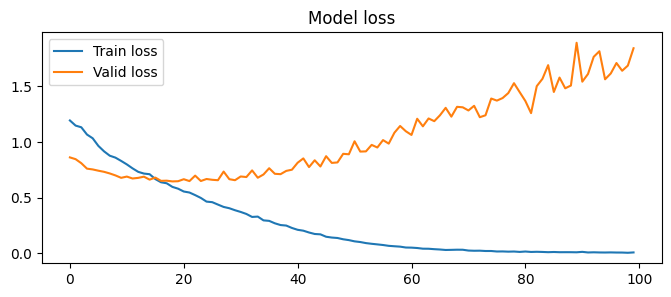

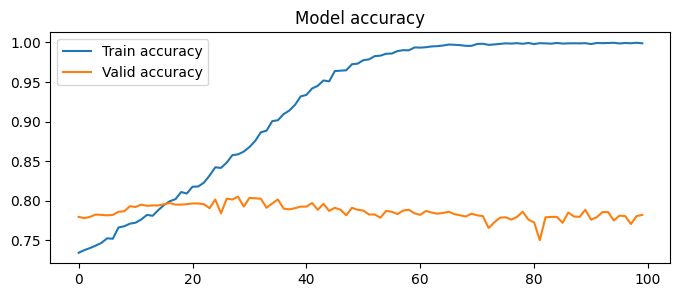

In [205]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
best_model, best_f1 = fit(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=100)

там написано f1, но на самом деле, там accuracy_score, можете в коде посмотреть

# Вывод

я обучил простую модель, кототорая, не сотря на это, дала хорошую точность на тесте. архитектуру более сложной я так же представил, но не обучил.

In [30]:
torch.save(model.state_dict(), 'my_model.pth')